# Initial Analyses and Data Handling

In this notebook, we are loading, cleaning, and doing initial processing and analysis of the Quotebank datasets from 2015 to 2020.
The notebook consists of the following:
- Data cleaning
- Descriptive statistics and plotting
- Handling of additional datasets
- Initial sentiment analysis
- Description and mathematical outline of methods

## Installing and Mounting

In [1]:
# Mounting of Google Drive to access the datasets

from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


Installing necessary libraries

In [2]:
pip install pandas==1.0.5

     |████████████████████████████████| 10.1 MB 6.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


In [ ]:
pip install pyarrow

In [ ]:
pip install nltk

In [1]:
pip install iteration_utilities

     |████████████████████████████████| 283 kB 7.7 MB/s 


## Imports

In [2]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Datapaths

In [3]:
path_to_file = '/content/drive/MyDrive/Quotebank/'

files_pre_cleaning = ['quotes-2015.json.bz2','quotes-2016.json.bz2','quotes-2017.json.bz2',
                  'quotes-2018.json.bz2','quotes-2019.json.bz2','quotes-2020.json.bz2']

files_cleaned = ['clean-quotes-2015.csv.bz2','clean-quotes-2016.csv.bz2','clean-quotes-2017.csv.bz2',
                  'clean-quotes-2018.csv.bz2','clean-quotes-2019.csv.bz2','clean-quotes-2020.csv.bz2']

path_to_wikidata_file = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'

## Data Cleaning


*In this part of the notebook, we do the necessary data cleaning for the project:*
 - Dropping rows with `NaN` or `None` values in the column `quotation`.
 - Dropping columns not related to our project to reduce the file size. We will remove the columns `quoteID` and `phase`. We know that all quotes in the Quotebank datasets from 2015 to 2020 are from "phase E". We do therefore consider these values as irrelevant.
 - Saving the cleaned data to avoid having to rerun the clean function. Due to issues with mounting to the EPFL drive on the deadline day, the rest of the analysis is run on the non-cleaned version of the dataset. In milestone 3, we plan to run it on the cleaned dataset.

*In addition to the cleaning described over, we want to highlight and discuss some findings from inspecting the data on the Quotebank website:*

- Some quotes are not in English. We choose not to remove these for two reasons: 1) They will not drastically affect our analysis, as they will probably be considered neutral. This is because the Vader lexicon we use for sentiment analysis does not include support for foreign languages. 2) It is hard to detect which quotes are in other languages, and it demands more work than reward.
- Some quotes are repetitive, e.g., "Yes, yes, yes, yes, yes, yes". As our sentiment analysis will give standardized results in the range `[-1, 1]`, these quotes will not be a problem for our analysis. It could also be argued that a quote of five "yes" should be considered more positive than a quote containing one "yes".
- Some of the quotes have `None` as the most probable speaker. When analyzing subsets of the data, this is something we have to consider. However, when analyzing the entire dataset, without looking at the speaker, this will not be a problem. We will, therefore, not do anything with this in the initial cleaning.

In [ ]:
def clean_data(chunk):
  ''' Cleaning a chunk of the data set by replacing 'None' values with NaN and dropping columns that will not be used in the project.

  Parameters
  ----------
  chunk: dataframe
    An uncleaned chunk of the data set.

  Returns
  -------
  chunk: dataframe
    A cleaned version of the chunk.
  '''

  # Replacing quotes of None with NaN values
  chunk['quotation'] = chunk['quotation'].replace('None', np.nan)

  # Dropping NaN values
  chunk = chunk.dropna(axis=0, subset=['quotation'])

  # Dropping column 'quoteID' and 'phase' to reduce filesize
  chunk = chunk.drop(axis=1, columns = 'quoteID')
  chunk = chunk.drop(axis=1, columns = 'phase')
  
  return chunk


# Reading and cleaning the data set in chunks and stores the cleaned data in compressed csv files
for x in range(len(files_pre_cleaning)):
  df_reader = pd.read_json(path_to_file + files_pre_cleaning[x], lines=True, compression='bz2', chunksize=500000)
  for chunk in df_reader:
      cleaned_chunk = clean_data(chunk)
      
      filename = files_cleaned[x]
      cleaned_chunk.to_csv(path_or_buf='/content/drive/MyDrive/CleanData/' + filename, compression='bz2', mode = 'a')

  print(f'Cleaned {files_pre_cleaning[x]}')


- Due to some issues with mounting of the EPFL drive on the deadline day, the rest of the analysis is ran on the non-cleaned version of the dataset. In milestone 3, we plan to run it on the cleaned dataset

# Describing the Data

Initially, we inspect the data, calculate descriptive statistics and visualize distributions. This analysis helps us detect errors and understand the data. 

## Helper Functions

Functions for dealing with date and time

In [5]:
def weekday_number(date):
  ''' Returning the weekday number of a date, e.g., 0 for Mondays.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday number.

  Returns
  -------
  weekday_number: int
    The weekday number of the date.
  '''

  weekday_number = date.weekday()
  return weekday_number


def weekday(date):
  ''' Returning the name of the weekday for a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  weekday: str
    The weekday of the date.
  '''
  
  day_number = date.weekday()
  week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  weekday = week_days[day_number]
  return weekday


def week(date):
  ''' Returning the week number of a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  week_number: int
    The week number of the date.
  '''

  week_number = date.week()
  return week_number


def month(date):
  ''' Returning the month name of date.

  Parameters
  ----------
  date: datetime
    A date for which to find the month name.

  Returns
  -------
  name_month: str
    The name of the month.
  '''
  name_month = date.month_name()
  return name_month


def add_time(chunk):
  ''' Adding columns for weekday, weekday number and month name to a chunk.

  Parameters
  ----------
  chunk: dataframe
    The chunk for which to add date information.

  Returns
  -------
  chunk: dataframe
    The chunk with date information.
  '''

  chunk['weekday'] = chunk['date'].apply(lambda x: weekday(x))
  chunk['weekday_number'] = chunk['date'].apply(lambda x: weekday_number(x))  
  chunk['Month'] =  chunk['date'].apply(lambda x: month(x))
  chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
  return chunk


Helper functions for dealing with dictionaries

In [ ]:
def add_dict(key, dictionary):
  ''' Incrementing the value of a key in a dictionary.
  
  Parameters
  ----------
  key: object
    The key for which to increment the value.
  
  dictionary: dict
    A dictionary in which we are incrementing the value of the key, or adding the key if not already present.

  Returns
  -------
  dictionary: dict
    The given dictionary after incrementing the value.
  '''
  
  if key in dictionary:
    dictionary[key] += 1
  else:
    dictionary[key] = 1
  return dictionary


def to_dict(dictionary, chunk_column):
  ''' Making a column of a dataframe into a dictionary, e.g., making a dictionary where weekdays are keys,
  and the values are the number of occurences of the key in the key.
  
  Parameters
  ----------
  dictionary: dict
    An initalized dictionary, either containing some preset keys or empty.
  
  chunk_column: series
    A series containing a column of a dataframe.

  Returns
  -------
  dictionary: dict
    A dictionary containing the desired values and keys as descripted.
  '''

  chunk_column.apply(lambda x: add_dict(x, dictionary))
  return dictionary



Functions for extracting media information

In [12]:
def find_media(url, medias_list):
  ''' Returning the media outlet where the quote is found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  url: array
    An entry in the column 'urls' of the Quotebank dataset, where the first value is the first source where the quote was found.
  
  medias_list: array
    An array containing some chosen media outlets, e.g., 'nytimes'.
  
  Returns
  -------
  media: str
    The first entry in url if its present in medias_list.
  '''

  for string in medias_list:
    url_string = str(url[0])
    if string in url_string:
      media = string
      return media


def get_media(chunk, medias_list):
  ''' Adding column with the media outlet where the quote is first found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  chunk: dataframe  
    A chunk of the Quotebank dataset.

  medias_list: array
    An array containing some chosen media outlets represented as strings, e.g., 'nytimes'.

  Returns
  -------
  chunk: dataframe
    The given chunk of the dataset, now containing a column 'media_outlet' 
    keeping the media where the quote was first found.
  '''

  chunk['media_outlet'] = chunk['urls'].apply(lambda x: find_media(x, medias_list))
  return chunk


Functions for descriptive statistics

In [ ]:
def occurences_stats(chunk):
  ''' Returning the median and 75-th percentile of 'numOccurences' for the given chunk.
  
  Parameters
  ----------
  chunk: dataframe
    The dataframe keeping a chunk of the dataset.
  
  Returns
  -------
  chunk_stats: array
    An array containing the median and the 75-th percentile.
  '''
  
  median = chunk.numOccurrences.describe()['50%']
  third_quartile = chunk.numOccurrences.describe()['75%']
  chunk_stats = [median, third_quartile]
  return chunk_stats


def stats_entire_dataset(occurence_stats_list):
  ''' Aggregating and printing statistics on numOccurences for the entire data set based upon the values in occurence_stats_list.
  
  Parameters
  ----------
  occurence_stats_list: array
    A 2D-array containing inner arrays with median and 75th percentile for each chunk of the dataset.   
  '''

  avg_median = 0
  avg_75th = 0
  for element in occurence_stats_list:
    avg_median += element[0]
    avg_75th += element[1]
  avg_median = avg_median/len(occurence_stats_list)
  avg_75th = avg_75th/len(occurence_stats_list)

  print(f'Average of median for each chunk for numOccurences: {round(avg_median, 2)}')
  print(f'Average 75th quantile for each chunk for  numOccurences: {round(avg_75th, 2)}')


def add_length(chunk):
  ''' Helper function adding the length of each quote to a new column.
  
  Parameters
  ----------
  chunk: dataframe
    A chunk of the dataset.
    
  Returns
  -------
  chunk: dataframe
    The given chunk containing a 'len_quote' column.
  '''

  chunk['len_quote'] = chunk['quotation'].apply(lambda x: len(str(x)))
  return chunk

## Exploratory Data Analysis

Plotting the distribution of the length of quotes and number of occurences for one chunk of size 200 000 from the 2020 dataset

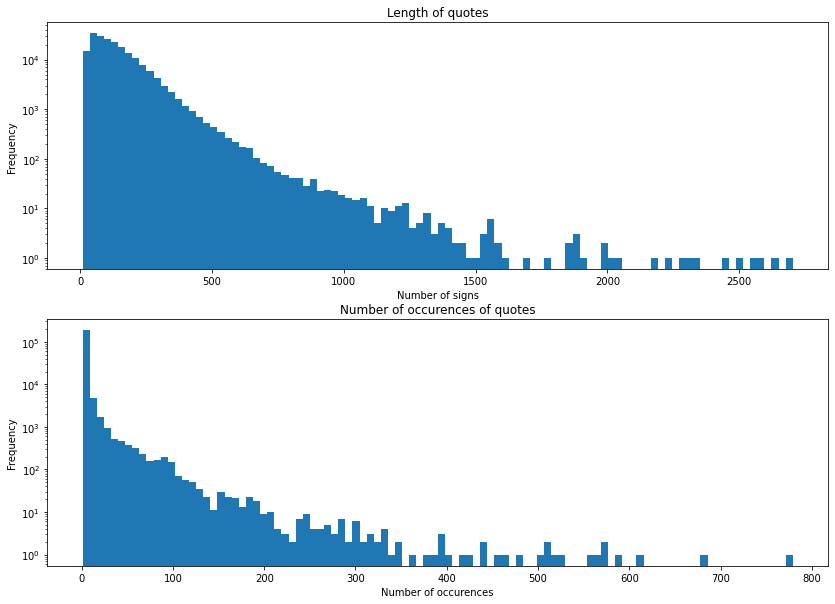

In [ ]:
# Loading one chunk of size 200 000 from the 2020 dataset.
df_reader = pd.read_json(path_to_file + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=200000)
for chunk in df_reader:
  break

# Adding a 'len_quote' column to the chunk
chunk = add_length(chunk)

# Plotting the distribution of 'len_quote' and 'numOccurences' for visual inspection
fix, ax = plt.subplots(2,1, figsize=(14,10))

ax[0].hist(chunk.len_quote, bins=100)
ax[0].set_title("Length of quotes")
ax[0].set_xlabel("Number of signs")
ax[0].set_ylabel("Frequency")
ax[0].set_yscale('log')

ax[1].hist(chunk.numOccurrences, bins=100)
ax[1].set_title("Number of occurences of quotes")
ax[1].set_xlabel("Number of occurences")
ax[1].set_ylabel("Frequency")
ax[1].set_yscale('log')

plt.show()


- The plots show that the length of quotes and the number of occurrences follow a heavy-tailed distribution. We keep this in mind when reporting descriptive statistics.
- We observe outliers in the form of long quotes. We do not remove these as we do not think they will affect our sentiment analysis. In addition, we have no reason to claim they are wrong, even though it could be reasoned that 2000+ sign quotes may result from misclassification from the Quotebank algorithm. 
- For the number of occurrences, we see that most quotes are quoted a few times, but some are repeated many times. This is important for our sentiment analysis since the quotation sentiment should be scaled by the number of occurrences to reflect the total sentiment in the media correctly.

In [ ]:
# Showing the head of a chunk of the 2020 dataset for visual inspection
chunk.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,len_quote
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E,276
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,91
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E,264
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E,33
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E,102


The data seems to have loaded as expected, and we do not notice some errors immediately.

Calculating statistics and gathering data on the whole dataset


In [ ]:
# Initializing an array that will store the mean and variance of 'numOccurences' as well as the size of a chunk
occurence_stats_list = []

# Initializing dictionaries for dates, weekdays and months that will store values for all the chunks
date_dictionary = {}

# Dictionaries for weekdays and months are initialized with keys to keep them in the correct order for later plotting
weekday_dictionary = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0,
                      'Friday': 0, 'Saturday': 0, 'Sunday': 0}

month_dictionary = {'January': 0, 'February': 0,'March': 0,
                    'April': 0, 'May': 0, 'June': 0, 
                    'July': 0, 'August': 0, 'September': 0,
                    'October': 0, 'November': 0, 'December': 0}

# Iterating through all the cleaned data sets in chunks
for x in range(len(files_pre_cleaning)): 
  print('Working on %d. dataset'%(x+1))
  df_reader = pd.read_json(path_to_file + files_pre_cleaning[x], lines=True, compression='bz2', chunksize=50000)
  for chunk in df_reader:
    chunk = add_time(chunk)
    
    # Inserting values in the dictionaries
    date_dictionary = to_dict(date_dictionary, chunk['date_short'])
    weekday_dictionary = to_dict(weekday_dictionary, chunk['weekday'])
    month_dictionary = to_dict(month_dictionary, chunk['Month'])

    # Generating descriptive stats for the chunk and adding them to occurence_stats_list
    occurence_stats_list.append(occurences_stats(chunk))

# Creating empty array to store dictionary values
arr = []
for element in date_dictionary.values():
    arr.append(element)
arr = np.array(arr)

# Calculating mean, std, and median for date_dictionary
mean = np.mean(arr)
std = np.std(arr)
median = np.median(arr)

Descriptive statistics for the number of quotes and the number of occurrences for quotes

In [ ]:
print(f'Mean of quotes per day: {round(mean, 2)}\nStandard deviation of quotes per day: {round(std, 2)}\nMedian of quotes per day: {round(median, 2)}\n')

# Printing the average of median and 75th quantile per chunk for numOccurences for the entire dataset
stats_entire_dataset(occurence_stats_list)

Mean of quotes per day: 59764.35
Standard deviation of quotes per day: 31690.1
Median of quotes per day: 64147.5

Average of median for each chunk for numOccurences: 1.0
Average 75th quantile for each chunk for  numOccurences: 2.0


- On average, there are around 60 000 quotations per day. The standard deviation is very high, probably because of the gaps in 2015-2017 that can be seen in the plot below.
- For the number of occurrences, we report the average of the median and the average of the 75th quantile for the chunks. This is because it follows a heavy-tailed distribution, and it is necessary to report robust statistics.
- We see that the average median per chunk for numOccurences is one and the 75th quantile is two. This shows that most quotes are quoted few times.

Barplot showing number of quotes per day for the entire dataset using log-scaled Y-axis

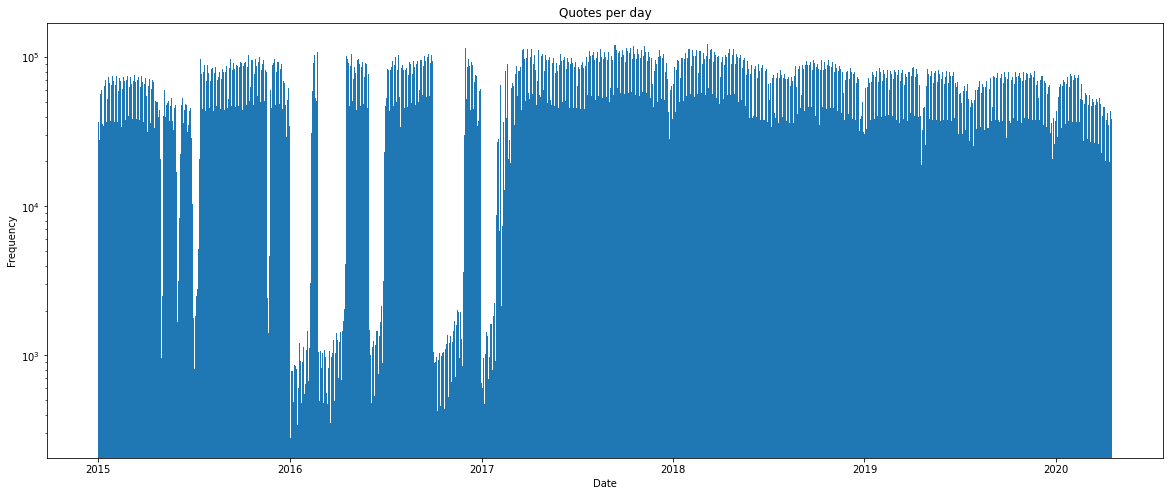

In [ ]:
fig, ax=plt.subplots(1,1, figsize = (20,8))
ax.bar(date_dictionary.keys(), date_dictionary.values(), width=1.0)
ax.set_title("Quotes per day")
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.set_yscale('log')
plt.show()

Barplot showing number of quotes per day for the entire dataset

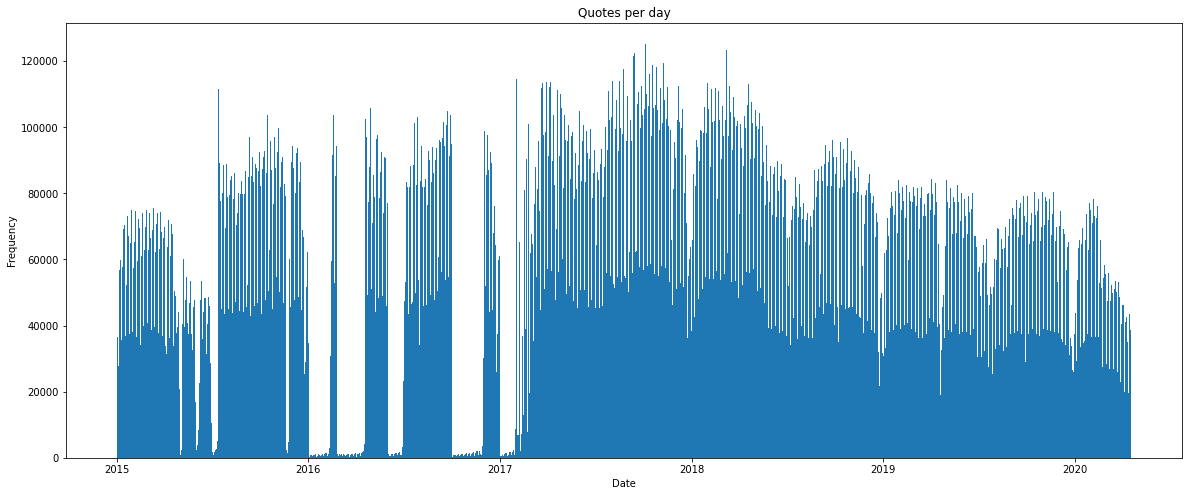

In [ ]:
fig, ax=plt.subplots(1,1, figsize = (20,8))
ax.bar(date_dictionary.keys(), date_dictionary.values(), width=1.0)
ax.set_title("Quotes per day")
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
plt.show()

- We notice that there are some large gaps between 2015 and 2017 where very few quotes was registered which should be kept in mind for future analyses

Barplot showing number of quotes per weekday

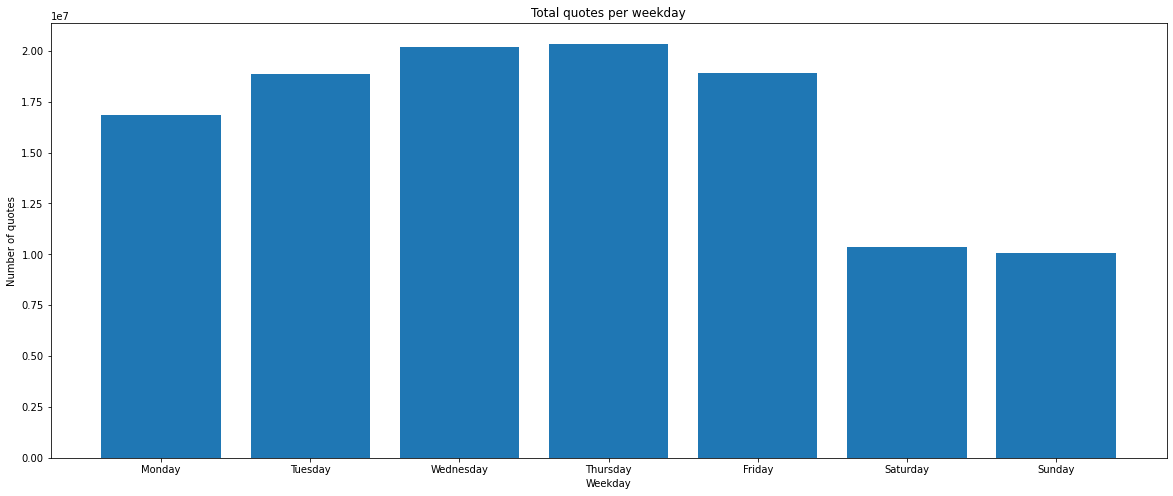

In [ ]:
fig, ax = plt.subplots(1, figsize = (20,8))
ax.bar(weekday_dictionary.keys(), weekday_dictionary.values())
ax.set_title("Total quotes per weekday")
ax.set_xlabel("Weekday")
ax.set_ylabel("Number of quotes")
plt.show()

- The plot shows, as expected, that there are fewer quotes in the weekends

Barplot showing number of quotes per month

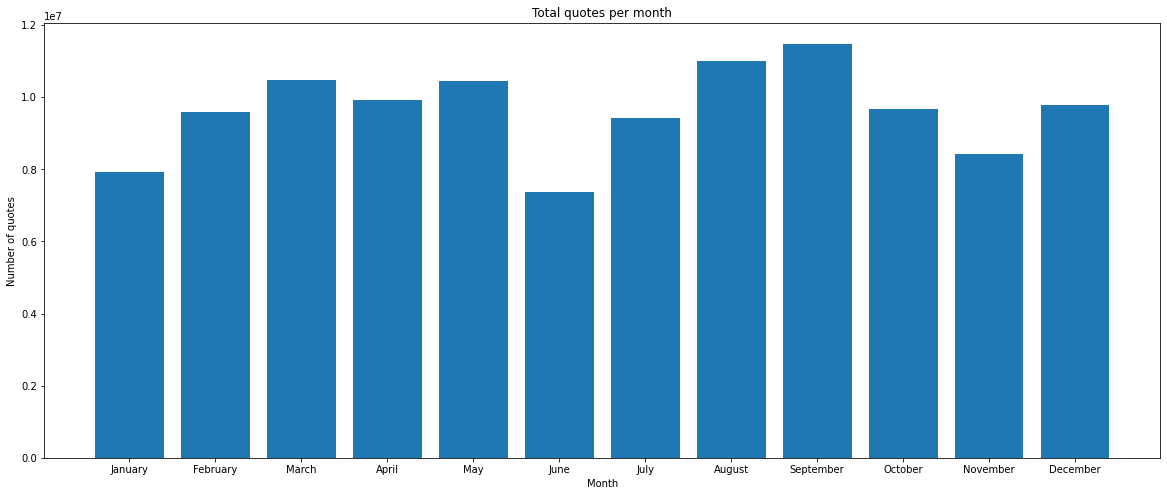

In [ ]:
fig, ax = plt.subplots(1, figsize = (20,8))
ax.bar(month_dictionary.keys(), month_dictionary.values())
ax.set_title("Total quotes per month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of quotes")
plt.show()

- We see that the number of quotes varies across months. There are several natural reasons for this:
 - In 2020, only quotes from January to April are included
 - Between 2015 and 2017, there are, as aforementioned, gaps in quotes for some months. From this and the plots above, it seems like January, June, and November have been most severely impacted. 

# Additional dataset


As mentioned in the ReadMe, we will use the Wikidata dataset to enrich our analyses. It will mainly be used for determining whether a speaker is a man or woman and whether the speaker is a politician or not. In this section, we have included the necessary code to extract this information from the dataset. This means that the data is ready to use for analysis in milestone 3.

In [4]:
# Reading the Wikidata files
read_wikidata_parquet = pd.read_parquet(path_to_wikidata_file)

read_wikidata_parquet.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


The wikidata dataset loaded as expected

Functions for extracting quotes by politicians and gender

In [ ]:
def find_alias_in_wiki(alias):
  ''' Returning a dataframe, consisting of one row, with Wikidata information about the given alias .
  
  Parameters
  ----------
  alias: str
    A given alias to look up in the Wikidata files
    
  Returns
  -------
  match: dataframe
    A dataframe containing information about the given alias.
  '''
  
  index = []
  for i, aliases in enumerate(read_wikidata_parquet['aliases']):
    if aliases is None:
      continue
    if alias in aliases:
        index.append(i)
  
  match = read_wikidata_parquet.loc[index]
  return match

# Testing the above function by looking up President Washington
print(find_alias_in_wiki("President Washington"))


                                             aliases  ...   religion
0  [Washington, President Washington, G. Washingt...  ...  [Q682443]

[1 rows x 15 columns]


In [ ]:
def dataset_filtered_on_aliases(aliases, dataset):
  '''Returning a filtered dataframe containing rows where 'speaker' is present in aliases array.
  
  Parameters
  ----------
  aliases: array
    An array containing desired aliases to filter on.
    
  dataset: dataframe
    The dataframe to filter.
    
  Returns
  -------
  dataset_alias_filtered: dataframe
    The given dataset filtered as described.
  '''
  
  dataset_alias_filtered = dataset[dataset['speaker'].isin(aliases)]
  # Replacing speakers of None with NaN values
  dataset_alias_filtered['speaker'] = dataset_alias_filtered['speaker'].replace('None', np.nan)
  # Dropping NaN values
  dataset_alias_filtered = dataset_alias_filtered.dropna(axis=0, subset=['speaker'])
  return dataset_alias_filtered


def dataset_filtered_on_politicians(wikidata, dataset):
  ''' Returning a filtered dataframe only containing quotes by politicians. 
  Note that a person can be listed with many professions and therefore distringuishing
  someone who is a former politican can be difficult.

  Parameters
  ----------
  wikidata: dataframe
    A dataframe containing the Wikidata dataset.

  dataset: dataframe
    A dataframe to filter on politicians.

  Returns
  -------
  dataset_filtered_on_politicans: dataframe
    A dataframe filtered as described.
  '''

  wikidata['politician'] = wikidata['occupation'].apply(lambda x: isPolitician(x))
  wikidata_politician_filtered = wikidata[wikidata.politician]
  
  # After filtering on occupation, turns all aliases into 1D list
  all_wiki_aliases_politician_filtered = wikidata_politician_filtered['aliases'].tolist()
  all_wiki_aliases_politician_filtered = list(deepflatten(all_wiki_aliases_politician_filtered, depth=1))

  # Returns original dataset filtered on the speakers corresponding to politicians
  dataset_filtered_on_politicans = dataset_filtered_on_aliases(all_wiki_aliases_politician_filtered, dataset)
  return dataset_filtered_on_politicans


def conv_to_string(x):
  ''' Converting the first element of a list x to a string. 
  If the input not is a list, it returns 'N/A.

  Parameters
  ----------
  x: array
    An array where we want to convert the first element into a string.

  Returns
  -------
  first_elem: str
    The first element of the array converted into a string or 'N/A' if the input is not a list.
  '''

  try:
    first_elem = str(x[0])
    return first_elem
  except:
    return 'N/A'

def isPolitician(array):
  ''' Checking whether the QID for the politician occupation is in array.
  
  Parameters
  ----------
  array: array 
    An array to check whether the QID is in.
    
  Returns
  -------
  bool
    A boolean telling whether the QID correspond to a polication or not.'''

  try:
    # Uses harcoded QID for politician == Q82955
    if 'Q82955' in array:
      return True
    else:
      return False
  except:
    return False

def dataset_filtered_on_gender_with_alias(gender, wikidata, dataset):
  ''' Filtering dataset on gender given the information in Wikidata
      Only includes a row if the speaker is not 'None'.
  Parameters
  ----------
  gender: str
    A string either 'male' or 'female'.
  
  wikidata: dataframe
    A dataframe containing the Wikidata dataset.

  dataset: dataframe
    The dataset to filter on gender.

  Returns
  -------
  dataframe
    The given dataset filtered on gender.
  '''
  
  if gender == 'male' or gender == 'female':
    gender_qid = 'Q6581097' if gender == 'male' else 'Q6581072'
    # Converting the gender column to string to be able to check if it equals gender_qid
    wikidata['gender'] = wikidata['gender'].apply(lambda x: conv_to_string(x))
    wikidata_gender_filtered = wikidata.loc[wikidata['gender'] == gender_qid]

  else:
    print("Invalid gender, the function does only consider binary genders.")
    exit()
  
  # After filtering on gender, make turn all aliases into 1D list
  all_wiki_aliases_gender_filtered = wikidata_gender_filtered['aliases'].tolist()
  all_wiki_aliases_gender_filtered = list(deepflatten(all_wiki_aliases_gender_filtered, depth=1))
  
  # Returning original dataset filtered on the speakers corresponding to a gender
  return dataset_filtered_on_aliases(all_wiki_aliases_gender_filtered, dataset)

Testing the functions

In [ ]:
# Testing whether the above-mentioned functions work by creating two dataframes. 
# 'males' includes only male speakers while 'politicians' includes only speakers that are politicans.
df_reader = pd.read_json(path_to_file + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=100000)
for chunk in df_reader:
  males = dataset_filtered_on_gender_with_alias('male', read_wikidata_parquet, chunk)
  politicians = dataset_filtered_on_politicians(read_wikidata_parquet, chunk)
  break

In [ ]:
males.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
25,2020-02-18-000907,A city is not an accident but the result of co...,Leon Krier,[Q970000],2020-02-18 09:39:38,1,"[[Leon Krier, 0.8559], [None, 0.1441]]",[http://allafrica.com/stories/202002180401.html],E
29,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],2020-01-26 13:21:36,11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
34,2020-02-29-000491,a lack of resources and government funding,Paul Harvey,"[Q16195572, Q16204369, Q39074951, Q47350253, Q...",2020-02-29 00:13:45,1,"[[Paul Harvey, 0.9212], [None, 0.0788]]",[http://basingstokegazette.co.uk/news/18270936...,E
62,2020-02-17-001857,"Absolutely they could (cause some upsets),",Tim Cridland,[Q8065902],2020-02-17 00:40:00,1,"[[Tim Cridland, 0.9051], [None, 0.0949]]",[http://www.dailymercury.com.au/news/rival-ski...,E
68,2020-04-03-002052,After talking with Chris about his background ...,Brad Smith,"[Q15477554, Q16218831, Q23664265, Q24084114, Q...",2020-04-03 15:16:31,1,"[[Brad Smith, 0.7482], [None, 0.2469], [Chris ...",[http://www.hmenews.com/article/brief-package-...,E


The male filtering seems to have worked as expected

In [ ]:
politicians.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
29,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],2020-01-26 13:21:36,11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
72,2020-02-07-003833,All future inquiries should be directed to the...,Seamus Ryan,[Q7440788],2020-02-07 22:11:55,1,"[[Seamus Ryan, 0.6351], [None, 0.3649]]",[https://www.koaa.com/news/news5-investigates/...,E
88,2020-01-23-004492,"Although not a lubricant issue, tire wear is e...",John Burke,"[Q15451851, Q16188889, Q16297972, Q1699458, Q2...",2020-01-23 16:23:57,1,"[[John Burke, 0.7478], [None, 0.2522]]",[http://www.theenergycollective.com/node/40103...,E
105,2020-01-09-005110,And his own drama is that he's stuck in this c...,John Moore,"[Q10500229, Q1537696, Q16089768, Q16106364, Q1...",2020-01-09 06:00:48,1,"[[John Moore, 0.7892], [None, 0.2108]]",[https://www.seattletimes.com/entertainment/mo...,E
109,2020-01-23-005418,And I think we've come to a time where we are ...,Sheila Oliver,[Q7493177],2020-01-23 21:15:14,1,"[[Sheila Oliver, 0.9228], [None, 0.0772]]",[https://wobm.com/how-toxic-is-nj-political-cl...,E


A quick Google search indicates that the filtering has worked for politicians as well



# Initial Sentiment Analysis

To test the feasibility of our project, we decided to investigate some of our research questions on a chunk from the 2020 dataset consisting of 500 000 quotes.

In this section, we often refer to the compound sentiment score from the NLTK library. Shortly, the compound score references the total sentiment of a quote standardized to be between -1 and 1. More information can be found at the bottom of this notebook under **Methods**

Our initial results vary in significance and size, as the code below shows. However, some results indicate that it is feasible to find exciting insights. Especially, there seems to be a significant difference in mood across media outlets. However, we need to test it on the full dataset to figure if this is the case. 

In [6]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Reading the data in chunks
df_reader = pd.read_json(path_to_file + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=500000)
for chunk in df_reader:

  # Calculating compound sentiment scores for the chunk and append the values in a column
  chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

  # Extracting the sentiments for Mondays and Fridays
  chunk = add_time(chunk)
  monday_quotes = chunk.loc[chunk['weekday_number'] == 0]
  friday_quotes = chunk.loc[chunk['weekday_number'] == 4]

  break


Plotting the sentiment scores for the chunk on a log-scaled Y-axis

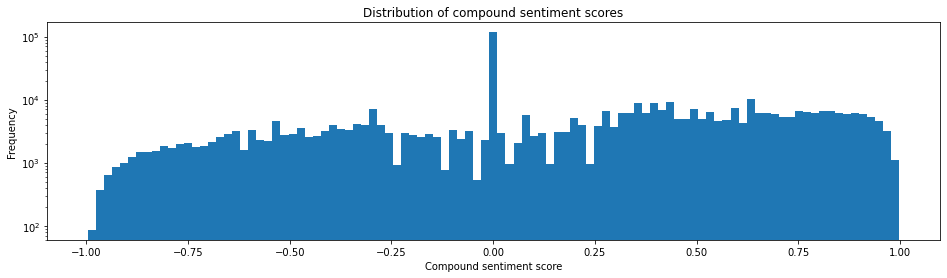

In [8]:
fig, ax = plt.subplots(1,1, figsize = (16,4))
ax.hist(chunk['compound'], 101)
ax.set_title('Distribution of compound sentiment scores') 
ax.set_xlabel('Compound sentiment score')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

We observe that the most common compund sentiment score is around 0. This makes sense as the Vader lexicon only changes the sentiment score from 0 if there is positive or negative words included in a sentence.

Printing quote and compound score for five quotations

In [ ]:
# Iterating through a sample of the chunk to show the compounds
for x in range(100,105):
    sentence = chunk['quotation'][x]
    print(sentence)
    compound = sent_analyzer.polarity_scores(sentence)['compound']
    print(f'Compound: {str(compound)}\n')

And [ festivalgoers ] are also drawn to coming in to Whanganui as well so I think it's great.
Compound: 0.8255

And for the record, Eamonn Holmes made me laugh, he lightened a very emotional moment and I'm very happy that he did.
Compound: 0.8586

And he stood there patiently and said, `I'm here to help you. I want to help you.' And I would roll up my window and look the other way.
Compound: 0.6908

and he was trying to tie the record of Harry Vardon: six British Opens. He was under a lot of pressure also. We were not close, but champions in the same category never are close. You never see both go outside for dinner. Never. That's not because it is personal. The competition carries on, not just on the golf course, but off the golf course also. It was that way for me and Watson.
Compound: -0.6444

And help he always did. For someone who preferred to be behind the scenes, he was at the center of absolutely everything.
Compound: 0.4019



The first three sentences and the fifth look quite correctly classified, but the fourth sentence recieved a more negative compound score than we expected. This inaccuracy is important to keep in mind during future analysis.

Inspecting the sentiment scores for Mondays and Fridays

In [ ]:
print("Sentiment statistics for quotes quoted on Mondays:")
print(monday_quotes['compound'].describe())
print("\nSentiment statistics for quotes quoted on Fridays:")
print(friday_quotes['compound'].describe())

Sentiment statistics for quotes quoted on Mondays:
count    72991.000000
mean         0.177723
std          0.467393
min         -0.996900
25%          0.000000
50%          0.088000
75%          0.571900
max          0.997800
Name: compound, dtype: float64

Sentiment statistics for quotes quoted on Fridays:
count    81629.000000
mean         0.174108
std          0.466973
min         -0.996400
25%          0.000000
50%          0.077200
75%          0.569900
max          0.998200
Name: compound, dtype: float64


The mean sentiment on Mondays and Fridays is quite similar but the sentiment is, contrary to our expectations, slightly higher on Mondays. 

Performing a t-test to see if the sentiment is different on Mondays and Fridays

In [9]:
t, p = stats.ttest_ind(monday_quotes['compound'], friday_quotes['compound'])
print("Two sided paired t-test with null hypothesis: The mean mood on Mondays equals the mean mood on Fridays.")
print(f"t-value: {round(t, 4)}, p-value: {round(p, 4)}")

Two sided paired t-test with null hypothesis: The mean mood on Mondays equals the mean mood on Fridays.
t-value: 1.519, p-value: 0.1288


- We do a t-test on different sentiments on Monday and Friday with H0: The mean compound sentiment score on Mondays and Fridays is different.
- We do not reject the null at a significance level of 5%. This means that we cannot conclude that the mood in the media is more positive on Mondays than on Fridays, even though the mean is higher on Mondays.

Finding the number of quotes in the chunk from the medias in the media_outlets list

In [13]:
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp']
chunk = get_media(chunk, media_outlets)
for element in media_outlets:
    media_chunk = chunk.loc[chunk['media_outlet'] == element]
    print("Number of quotes in %s: %d"%(element, media_chunk.shape[0]))

Number of quotes in nytimes: 3568
Number of quotes in wsj: 378
Number of quotes in womansday: 31
Number of quotes in nbcnews: 1568
Number of quotes in foxnews: 3945
Number of quotes in aarp: 94


The number of quotes from media outlets varies greatly

Descriptive statistics of the compound sentiment score for media outlets



In [14]:
# Looking at the differences in the sentiment across media outlets
nytimes = chunk.loc[chunk['media_outlet']=='nytimes']

print("Sentiment scores for quotes in New York Times:")
print(nytimes['compound'].describe())

Sentiment scores for quotes in New York Times:
count    3568.000000
mean        0.074247
std         0.404358
min        -0.958400
25%        -0.077200
50%         0.000000
75%         0.386750
max         0.981600
Name: compound, dtype: float64


In [15]:
wsj = chunk.loc[chunk['media_outlet']=='wsj']

print("Sentiment scores for quotes in the Wall Street Journal:")
print(wsj['compound'].describe())

Sentiment scores for quotes in the Wall Street Journal:
count    378.000000
mean       0.161874
std        0.441007
min       -0.880500
25%        0.000000
50%        0.041350
75%        0.510600
max        0.978100
Name: compound, dtype: float64


In [ ]:
womansday = chunk.loc[chunk['media_outlet']=='womansday']

print("Sentiment scores for quotes in the Womansday:")
print(womansday['compound'].describe())

Sentiment scores for quotes in the Womansday:
count    31.000000
mean      0.186561
std       0.518135
min      -0.743000
25%      -0.177000
50%       0.000000
75%       0.669700
max       0.962700
Name: compound, dtype: float64


In [ ]:
fox = chunk.loc[chunk['media_outlet']=='foxnews']

print("Sentiment scores for quotes in FOX news:")
print(fox['compound'].describe())

Sentiment scores for quotes in FOX news:
count    3945.000000
mean        0.093046
std         0.474749
min        -0.971900
25%        -0.226300
50%         0.000000
75%         0.476700
max         0.992300
Name: compound, dtype: float64


- We see that the mean of the different media outlets varies, with NYTimes and FOX news having the lower mean sentiment, and Wall Street Journal and Womansday having the higher mean sentiment.
- The variance in sentiment is the greatest for Womansday, but this may be caused by the low number of quotes

Testing for difference in sentiment across media outlets

In [16]:
t, p = stats.ttest_ind(nytimes['compound'], wsj['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:")
print(f"t-value: {round(t,4)}, p-value: {round(p,4)}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:
t-value: -3.7018, p-value: 0.0002


- We do a Welch t-test with H0: The mean compound sentiment score for NYTimes and Wall Street Journal is equal
- We reject the null hypotesis with a significance level of 5%
- It is interesting to see that the significance level is strong, and additionally that the mean difference is big (0.0876). We will analyze this further in Milestone 3 to determine if we can conclude that the mood is more positive in Wall Street Journal.

# Mathematical Outline of Methods
The following cells will deal with the necessary outline of the mathematical concepts that will be used in our analysis
* t-test
* Welch's t-test
* Confidence intervals
* Natural language processing methods

## Statistical methods

### t-test

To test whether our results are statistically significant, we will use paired t-tests. The assumption needed to make t-test a valid form for hypothesis test is that the test-statistic is normally distributed. Since we will use the t-test for very large N, and the t-statistic is a sum of independent and identically distributed random variables, this assumption will hold of the central limit theorem.

We will use the t-test to test the differences in mood in different scenarios. For example, to test if the mood in the media on Fridays is more positive than on Mondays. 

The t-statistic:

${t} = \frac{\bar D-\mu _D}{s_D / \sqrt n}$

where $\bar D$ is the sample mean difference between the two distributions. $ \mu _D$ is the real mean difference. $s_D$ is the sample standard deviation of the difference $\bar D$, and $n$ is the number of observations.

As our null hypothesis we will use $H_0: \mu _D = 0$

### Welch's t-test

We will also use Welch's t-test which is a variant of the t-test for when the two populations we study have unequal variance.

The t-test will for example be used to test the different in sentiment between media outlets as above.

The Welch t-statistic:

${t} = \frac{\bar X_1-\bar X_2}{\sqrt {\frac{s_1^2}{N_1}+\frac{s_2^2}{N_2}}}$

where $\bar X_1- \bar X_2$ is the sample mean difference between the two distributions, $s_i$ is the empirical standard error for $X_i$, and $N_i$ is the number of observations for $X_i$.

Our null hyopthesis for the Welch t-test is also that that the two population means are equal.

### Confidence Intervals

We will also utilize confidence intervals to estimate the uncertatinty of our results. The confidence intervals is based on the aforementioned test statistic:

$ CI = [\bar D - t_{n-1,  \frac{\alpha}{2}} s_D / \sqrt n,  \bar D + t_{n-1,  \frac{\alpha}{2}} s_D / \sqrt n ]$

Where $t_{n-1, \frac{\alpha}{2}}$ is the critical value of a student-t distribution with $n-1$ degrees of freedom and significance level $\alpha$.

## Natural Language Processing

We will utilize NLTK, a Python library for Natural Language Processing, to complete this project’s natural language processing task. More information about NLTK can be found at _https://www.nltk.org/index.html_, or in the NLT book [1].
### Sentiment Analysis

To study the changes in mood in the media, we will utilize sentiment analysis. Our sentiment analysis will aim to classify whether a quote is positive, neutral, or negative and to which extent it is positive or negative. 

To conduct the sentiment analysis, we will use the [nltk.sentiment.vader](_https://www.nltk.org/api/nltk.sentiment.vader.html_) module. This module uses the Vader rule-based model for sentiment analysis [2]. Vader’s sentiment lexicon consists of over 7500 lexical features, assigned an intensity score between -4 and 4. 

We chose the Vader module because it differentiates between slightly positive words and very positive words. This way, we can capture nuances in the sentiment of quotes.

To quantify the sentiment, we will use the compound score provided by the Vader module. This score is calculated by normalizing the sum of valence scores for the individual words in the quote. The valence scores are calculated by finding the word score in the Vader lexicon. It does also include heuristics, such as giving extra weight to words written in upper case. To summarize, the following formulas calculate the compound score:

$compoundScore = \frac{sum_s}{\sqrt{(sum_s^2+15)}}$ where $sum_s =\sum_{i=1}^{n} valenceScore_i$

# References

1. Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.
2. Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.